In [1]:
%matplotlib inline

# Example 7.6.1: Mine management
import numpy as np
import matplotlib.pyplot as plt

class MineManagement:
    
    def __init__(self, price, sbar, delta):
        self.price, self.sbar, self.delta = price, sbar, delta
    
    def get_value(self, v_next):
        v_mat = np.array([[self.get_value_sub(s, x, v_next)
            for x in range(self.sbar)] for s in range(self.sbar)])
        return np.max(v_mat, axis=1)
        
    def get_value_sub(self, s, x, v_next):
        return self.reward(s, x) + self.delta * v_next[self.transition(s, x)]

    def reward(self, s, x):
        if s < x:
            return -np.inf
        return self.price * x - self.cost(s, x)

    def cost(self, s, x):
        return x ** 2 / (1 + s)
    
    def transition(self, s, x):
        return s - x
    
    def get_policy(self, s, v):
        return np.argmax([self.get_value_sub(s, x, v) for x in range(self.sbar)])
    
    def value_function_iteration(self):
        v = np.zeros(self.sbar)
        while np.linalg.norm(v - self.get_value(v)) > 1.0e-8:
            v = self.get_value(v)
        policy = np.array([self.get_policy(s, v) for s in range(self.sbar)])
        return v, policy


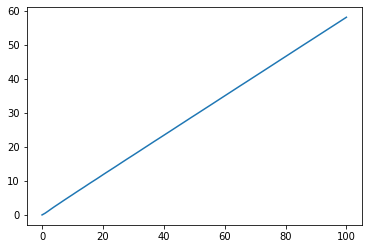

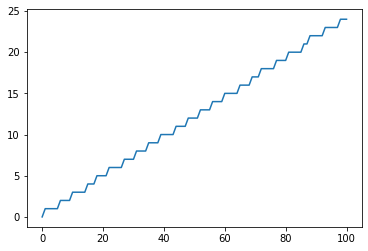

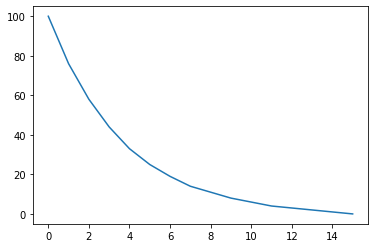

In [2]:
price, sbar, delta = 1, 101, 0.9
mine = MineManagement(price, sbar, delta)
value, policy = mine.value_function_iteration()
state = np.array([i for i in range(sbar)])

plt.plot(state, value)
plt.show()

plt.plot(state, policy)
plt.show()

path_state = [sbar - 1]
t = [0]
while path_state[-1] > 0:
    s = path_state[-1]
    path_state.append(mine.transition(s, policy[s]))
    t.append(t[-1] + 1)

plt.plot(t, path_state)
plt.show()

In [3]:
# Example 7.6.1: Asset replacement
class AssetReplacement:

    def __init__(self, maxage, repcost, delta):
        self.maxage, self.repcost, self.delta = maxage, repcost, delta
    
    def reward(self, a):
        return 50 - 2.5 * a - 2.5 * a ** 2

    def get_value_sub(self, a, x, value_next):
        if x == 1:
            return self.reward(0) - self.repcost + self.delta * value_next[1]
        if a == self.maxage:
            return -np.inf
        return self.reward(a) + self.delta * value_next[a + 1]
    
    def get_value(self, value_next):
        v_mat = np.array([[self.get_value_sub(a, x, value_next)
            for x in [0, 1]] for a in range(self.maxage + 1)])
        return np.max(v_mat, axis=1)
    
    def get_policy(self, a, v):
        return np.argmax([self.get_value_sub(a, x, v) for x in range(self.maxage + 1)])
    
    def value_function_iteration(self):
        value = np.zeros(self.maxage + 1)
        while np.linalg.norm(value - self.get_value(value)) > 1.0e-8:
            value = self.get_value(value)
        policy = np.array([self.get_policy(a, value) for a in range(self.maxage + 1)])
        return value, policy

maxage, repcost, delta = 5, 75, 0.9
asset_replacement = AssetReplacement(maxage, repcost, delta)
asset_replacement.value_function_iteration()

(array([244.90404184, 216.56004649, 190.62227388, 172.91363765,
        169.90404184, 169.90404184]),
 array([0, 0, 0, 0, 1, 1], dtype=int64))

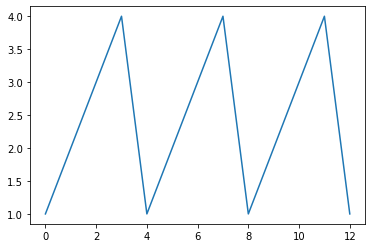

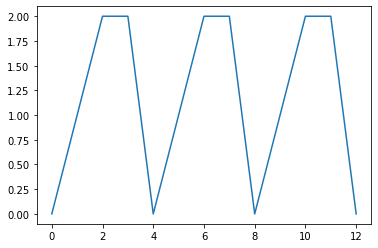

In [4]:
# Example 7.6.3: Asset replacement with maintenance
class AssetReplacement2:

    def __init__(self, maxage, repcost, mancost, delta):
        self.maxage, self.repcost, self.mancost, self.delta \
            = maxage, repcost, mancost, delta
        self.a_space = np.array([a for a in range(1, self.maxage + 1)])
        self.s_space = np.array([s for s in range(self.maxage)])
        self.state_space = np.array([[a, s] for a in self.a_space for s in self.s_space])
        self.na, self.ns = len(self.a_space), len(self.s_space)

    def transition(self, state, x):
        a, s = state
        if x == 0:
            return np.array([a + 1, s])
        if x == 1:
            return np.array([a + 1, s + 1])
        if x == 2:
            return np.array([1, 0])

    def reward_sub(self, a, s):
        return (1 - (a - s) / 5) * (50 - 2.5 * a - 2.5 * a**2)
    
    def reward(self, state, x):
        a, s = state
        if x == 0:
            return self.reward_sub(a, s)
        if x == 1:
            return self.reward_sub(a, s + 1) - self.mancost
        if x == 2:
            return self.reward_sub(0, 0) - self.repcost
    
    def get_state_idx(self, state):
        return self.ns * (state[0] - 1) + state[1]

    def get_value_sub(self, state, x, v):
        state_next = self.transition(state, x)
        state_idx = self.get_state_idx(state_next)
        if state_next[0] not in self.a_space or state_next[1] not in self.s_space \
                or state_next[0] < state_next[1]:
            return -np.inf
        return self.reward(state, x) + self.delta * v[state_idx]
    
    def get_value(self, v):
        v_mat = np.array([[self.get_value_sub(state, x, v) for x in range(3)]
            for state in self.state_space])
        return np.max(v_mat, axis=1)

    def get_policy(self, state, v):
        return np.argmax([self.get_value_sub(state, x, v) for x in range(3)])
    
    def value_function_iteration(self):
        value = np.zeros(self.na * self.ns)
        while np.linalg.norm(value - self.get_value(value)) > 1.0e-8:
            value = self.get_value(value)
        policy = np.array([self.get_policy(state, value) for state in self.state_space])
        return value, policy

maxage, repcost, mancost, delta = 5, 75, 10, 0.9
asset_replacement2 = AssetReplacement2(maxage, repcost, mancost, delta)
value, policy = asset_replacement2.value_function_iteration()

ts = np.array([i for i in range(13)])
state, path_state = np.array([1, 0]), [np.array([1, 0])]
for t in ts[1:]:
    action = asset_replacement2.get_policy(state, value)
    state = asset_replacement2.transition(state, action)
    path_state.append(state)

path_a, path_s = list(zip(*path_state))
plt.plot(ts, path_a)
plt.show()

plt.plot(ts, path_s)
plt.show()

In [5]:
# Example 7.6.4: Option pricing
class OptionPrice:

    def __init__(self, T, sigma, r, strike, p0, N):
        self.T, self.sigma,  self.r, self.strike, self.p0, self.N \
            = T, sigma, r, strike, p0, N
        self.tau = self.T / self.N
        self.delta = np.exp(-self.r * self.tau)
        self.u = np.exp(self.sigma * np.sqrt(self.tau))
        self.q = 0.5 + np.sqrt(self.tau) * (self.r - 0.5 * self.sigma ** 2) / (2 * self.sigma)
        self.states = np.array([self.p0 * self.u ** i for i in range(-self.N, self.N + 1)])
        self.nstates = len(self.states)
        self.transition = self._get_transition_mat()
        self.v_last = np.zeros(self.nstates)

    def _get_element(self, i, j):
        return self.q * (j == min(i + 1, self.nstates - 1)) \
            + (1 - self.q) * (j == max(i - 1, 0))

    def _get_transition_mat(self):
        return np.array([[self._get_element(i, j) for j in range(self.nstates)] for i in range(self.nstates)])

    def get_value(self, v_next):
        v_keep = self.delta * self.transition @ v_next
        value = np.array([max(self.strike - p, v) for v, p in zip(v_keep, self.states)])
        action = np.vectorize(int)(value == self.strike - self.states)
        return value, action

    def solve(self):
        value, policy = [], []
        value_next = self.v_last
        for i in range(self.N):
            value_next, action = self.get_value(value_next)
            value.append(value_next), policy.append(action)
        return np.array(value), np.array(policy)

T, sigma, r, strike, p0, N = 0.5, 0.2, 0.05, 2.1, 2.0, 100
# With r = 0.025, the result becomes similar to the textbook result
option_price = OptionPrice(T, sigma, r, strike, p0, N)
value, policy = option_price.solve()

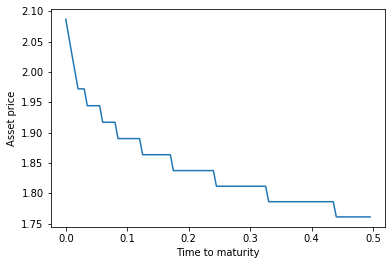

In [6]:
threshold = [list(x).index(0) - 1 for x in policy]
p_threshold = [option_price.states[i] for i in threshold]
t = [option_price.tau * i for i in range(len(p_threshold))]
plt.plot(t, p_threshold)
plt.xlabel('Time to maturity')
plt.ylabel('Asset price')
plt.show()


In [7]:
# Example 7.6.5: Water management
class WaterManagement:

    def __init__(self, delta, alpha1, alpha2, beta1, beta2, M):
        self.delta, self.alpha1, self.alpha2, self.beta1, self.beta2, self.M \
            = delta, alpha1, alpha2, beta1, beta2, M
        self.rains = np.array([i for i in range(5)])
        self.p = np.array([0.1, 0.2, 0.4, 0.2, 0.1])
        self.states = np.array([i for i in range(self.M + 1)])
        self.actions = np.array([i for i in range(self.M + 1)])
        self.nstates, self.nactions = len(self.states), len(self.actions)

    def F(self, x):
        return self.alpha1 * x ** self.beta1
    
    def U(self, s, x):
        return self.alpha2 * (s - x) ** self.beta2

    def reward(self, s, x):
        if s - x < 0 or s < 0:
            return -np.inf
        return self.F(x) + self.U(s, x)

    def expected_value(self, s, x, v_next):
        s_next = np.vectorize(lambda y: min(y, self.M))(s - x + self.rains)
        v_next_truncate = np.array([v_next[s] for s in s_next])
        return np.dot(self.p, v_next_truncate)

    def get_value_sub(self, s, x, v_next):
        return self.reward(s, x) + self.delta * self.expected_value(s, x, v_next)

    def get_value(self, v_next):
        v_mat = [[self.get_value_sub(s, x, v_next) for x in self.actions] for s in self.states]
        return np.max(v_mat, axis=1)
    
    def get_policy(self, s, v):
        return np.argmax([self.get_value_sub(s, x, v) for x in self.actions])

    def value_function_iteration(self):
        value = np.zeros(self.nstates)
        while np.linalg.norm(value - self.get_value(value))> 1.0e-8:
            value = self.get_value(value)
        policy = np.array([self.get_policy(s, value) for s in self.states])
        return value, policy

delta, alpha1, alpha2, beta1, beta2, M = 0.9, 14, 10, 0.8, 0.4, 30
wm = WaterManagement(delta, alpha1, alpha2, beta1, beta2, M)
value, policy = wm.value_function_iteration()

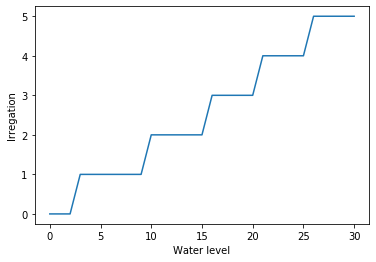

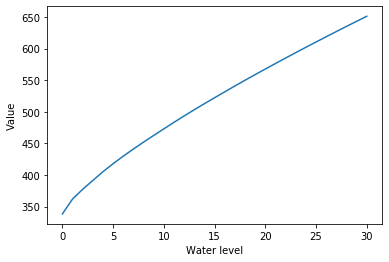

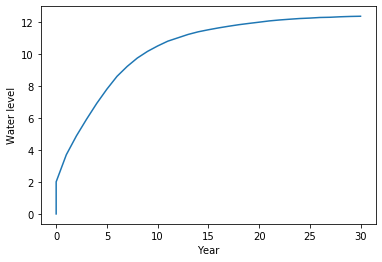

In [8]:
plt.plot(wm.states, policy)
plt.xlabel('Water level'), plt.ylabel('Irregation')
plt.show()

plt.plot(wm.states, value)
plt.xlabel('Water level'), plt.ylabel('Value')
plt.show()

# Simulation
def get_rain(rains, probs):
    u = np.random.rand()
    cum_p = 0
    for r, p in zip(rains, probs):
        cum_p += p
        if u <= cum_p:
            return r

nsim, nyears = 10000, 30
states, water_level, t = np.array([0] * nsim), [0], [0]
min_curried = np.vectorize(lambda x: min(x, wm.M))
for i in range(nyears + 1):
    x = np.array([policy[int(s)] for s in states])
    rains = np.array([get_rain(wm.rains, wm.p) for i in range(nsim)])
    states = min_curried(states - x + rains)
    water_level.append(states.mean()), t.append(i)

plt.plot(t, water_level)
plt.xlabel('Year'), plt.ylabel('Water level')
plt.show()


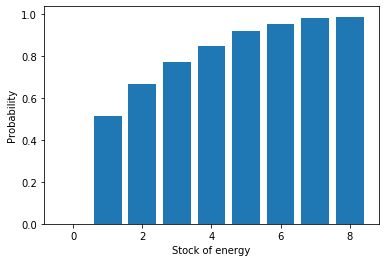

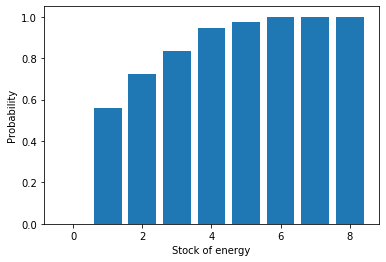

In [35]:
# Example 7.6.6
class Bioeconomy:

    def __init__(self, T, emax, e, p, q):
        self.T, self.emax, self.e, self.p, self.q \
            = T, emax, e, p, q
        self.states = np.array([i for i in range(self.emax + 1)])
        self.nstates = len(self.states)
        self.actions = np.array([a for a in range(len(self.p))])

    def get_value(self, a, e, v_next):
        if e == 0:
            return 0
        e_find = min(self.emax, e - 1 + self.e[a])
        e_notfind = max(e - 1, 0)
        p, q = self.p[a], self.q[a]
        return p * q * v_next[e_find] + p * (1 - q) * v_next[e_notfind]
    
    def get_policy(self, e, v_next):
        values = np.array([self.get_value(a, e, v_next) for a in self.actions])
        return np.argmax(values)
    
    def solve(self):
        v_next = np.array([0] + [1] * self.emax)
        value, policy = [], []
        for t in range(self.T):
            a_opt = np.array([self.get_policy(e, v_next) for e in self.states])
            v_next = np.array([self.get_value(a, e, v_next) for e, a in enumerate(a_opt)])
            value.append(v_next), policy.append(a_opt)
        return np.array(value), np.array(policy)

T, emax, e, p, q = 10, 8, np.array([2, 4, 5]), \
    np.array([1.0, 0.7, 0.8]), np.array([0.5, 0.8, 0.7])
bioeconomy = Bioeconomy(T, emax, e, p, q)
value, policy = bioeconomy.solve()

# Survival probability at priod 0
plt.bar(bioeconomy.states, value[-1])
plt.xlabel('Stock of energy')
plt.ylabel('Probability')
plt.show()

# Survival probability at period 5
plt.bar(bioeconomy.states, value[-6])
plt.xlabel('Stock of energy')
plt.ylabel('Probability')
plt.show()